In [ ]:
# I acknowledge to have used sources like stackoverflow and Google Collabs in-built debugging help to debug the code

In [36]:
#  loading the required libraries
from tensorflow.keras import layers, models, optimizers, callbacks, Input
import tensorflow as tf
import numpy as np
import random
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [37]:
# setting the seed values to my student id (for reproducability)
set_seed_val = 1898948
tf.random.set_seed(set_seed_val)
np.random.seed(set_seed_val)
random.seed(set_seed_val)


In [38]:
# Setting image resize value to ensure uniform shape and model compatibility
img_size=(224,224)

In [39]:
# Setting the batch size for approriate memory management and also defining the number of classes
batch_size = 16
num_classes = 2

In [40]:
# defining function to augment training set
def data_augment():
  # This function introduces random flips, rotation, zoom and brightness adjustment for the training dataset
    return tf.keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomBrightness(0.1),
    ])

data_augmentation = data_augment()


In [41]:
# paths to the dataset that is saved in my google drive
training_path = '/content/drive/MyDrive/dataset/train/dogs-person.tfrecord'
validation_path = '/content/drive/MyDrive/dataset/valid/dogs-person.tfrecord'
testing_path = '/content/drive/MyDrive/dataset/test/dogs-person.tfrecord'


In [42]:
#indtifying the feature names
r_data = tf.data.TFRecordDataset(training_path)

for r in r_data.take(10):
  rec = tf.train.Example()
  rec.ParseFromString(r.numpy())
  print(rec.features.feature.keys())

KeysView({'image/encoded': bytes_list {
  value: "\377\330\377\340\000\020JFIF\000\001\001\000\000\001\000\001\000\000\377\333\000C\000\010\006\006\007\006\005\010\007\007\007\t\t\010\n\014\024\r\014\013\013\014\031\022\023\017\024\035\032\037\036\035\032\034\034 $.\' \",#\034\034(7),01444\037\'9=82<.342\377\333\000C\001\t\t\t\014\013\014\030\r\r\0302!\034!22222222222222222222222222222222222222222222222222\377\300\000\021\010\002\320\003\300\003\001\"\000\002\021\001\003\021\001\377\304\000\037\000\000\001\005\001\001\001\001\001\001\000\000\000\000\000\000\000\000\001\002\003\004\005\006\007\010\t\n\013\377\304\000\265\020\000\002\001\003\003\002\004\003\005\005\004\004\000\000\001}\001\002\003\000\004\021\005\022!1A\006\023Qa\007\"q\0242\201\221\241\010#B\261\301\025R\321\360$3br\202\t\n\026\027\030\031\032%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\203\204\205\206\207\210\211\212\222\223\224\225\226\227\230\231\232\242\243\244\245\246\247\250\251\252\262\263\264\265\266\267\270\2

In [43]:
# as the dataset is TFRecord, we need to parse it properly
#first decoding the features from the image
feature_desc = {
    'image/encoded': tf.io.FixedLenFeature([], tf.string),
    'image/object/class/label': tf.io.VarLenFeature(tf.int64)
}



In [45]:
# function to parse TFRecord
def parse_tfrecord(img):
    features = tf.io.parse_single_example(img, feature_desc)
    #decoded image after parsing
    image = tf.io.decode_jpeg(features['image/encoded'], channels=3)

    # Setting image resize value to ensure uniform shape and model compatibility (normalization)
    image = tf.image.resize(image, img_size) / 255.0

    # getting the lable after parsing

    # initially got the error failed to convert elements of sparsetensor to tensor
    # so to cast to float32 for compatibility with binary_crossentropy first we need to convert it to dense
    label = tf.sparse.to_dense(features['image/object/class/label'], default_value=-1)

    classes =2
    label = tf.one_hot(label -1,classes)
    # print("hot:", tf.shape(one_labels))

    label = tf.math.reduce_max(label,axis=0)
    label=tf.reshape(label,[classes])
    label = tf.cast(label,tf.float32)
    # b_levels = tf.reshape(b_labels,[classes])
    # print(f"shape_label: {tf.shape(b_labels)}")
    # print("final binary labels:",b_labels)
    return image, label




In [14]:
# function to load the TFRecord datasets
def load_dataset(file_path, augment=False):
    dataset = tf.data.TFRecordDataset(file_path)
    dataset = dataset.map(parse_tfrecord)
    # only applying augmentation if training dataset
    if augment:
      #explicitly specifying trining
        dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y))
    #applying batch size and random shuffling
    return dataset.batch(batch_size).shuffle(1000).prefetch(tf.data.AUTOTUNE)

In [46]:
# getting the dataset using the above defined function
# explicitly passing the argument augment = True only for the training dataset
# If augmentation is applied to the testing dataset we might be comrpomising the validity of our models
train_dataset = load_dataset(training_path, augment=True)
val_dataset = load_dataset(validation_path, augment=False)
test_dataset = load_dataset(testing_path, augment=False)

In [47]:
# Initial run resulted in inf errors so checking for invalid labels
for images, labels in train_dataset.take(1):
  print("batch in labels", labels.numpy())

batch in labels [[-inf -inf]
 [  1.   1.]
 [  0.   1.]
 [  1.   1.]
 [  0.   1.]
 [-inf -inf]
 [  1.   0.]
 [  0.   1.]
 [  1.   0.]
 [  1.   1.]
 [  0.   1.]
 [  1.   0.]
 [  1.   1.]
 [  1.   1.]
 [  1.   0.]
 [  1.   1.]]


In [48]:
#  creating the invalid_lab function so that only valid labels are used
def invalid_lab(img,lab):
  return tf.reduce_all(tf.math.is_finite(lab))

train_dataset = train_dataset.filter(invalid_lab)
val_dataset = val_dataset.filter(invalid_lab)
test_dataset = test_dataset.filter(invalid_lab)

In [18]:
# validating all nan/invalid values are handled
def check_for_nan_inf(data):
    for images, labels in data.take(1):
        tf.debugging.check_numerics(images, "Found NaN or Inf in images")
        tf.debugging.check_numerics(labels, "Found NaN or Inf in labels")

# checking the dataset
check_for_nan_inf(train_dataset)
check_for_nan_inf(val_dataset)

In [49]:
# implementing a learning rate scheduler as the run time was high
def lr_scheduler(epoch, lr):
    r = lr * tf.math.exp(-0.1) if epoch >= 10 else lr
    return float(r)
lr_callback = callbacks.LearningRateScheduler(lr_scheduler)

**Defining the CNN models**

In [50]:
#  functionnfor ResNet-50

# during the initial runs, I had used the Sequential API to implement the CNN models
# Training went good, however, the problem was in testing, got the error for invalid number of arguments
# thus switched to the Functional API which worked well
def resnet50(input_shape):
  # defining the input shape
    input_layer = Input(shape=input_shape)
    # loading the model without top classification layer
    #  and as we are not using any pre-trained weights, weights = None is used
    base = tf.keras.applications.ResNet50(include_top=False, input_tensor=input_layer, weights=None)
    # for global average pooling which helps in spatial dimension reduction
    x = layers.GlobalAveragePooling2D()(base.output)
    # adding the sigmoid activation function to the output layer
    output_layer = layers.Dense(num_classes, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model

In [51]:
# function for MobileNetV2
def mobilenet(input_shape):
    input_layer = Input(shape=input_shape)
    # loading the model without top classification layer
    #  and as we are not using any pre-trained weights, weights = None is used
    base = tf.keras.applications.MobileNetV2(include_top=False, input_tensor=input_layer, weights=None)
    x = layers.GlobalAveragePooling2D()(base.output)
    # adding the sigmoid activation function to the output layer
    output_layer = layers.Dense(num_classes, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model



In [52]:
# function for the baseline custom CNN
def custom_cnn(input_shape):
    input_layer = Input(shape=input_shape)
    # first convolutional layer consists of 32 filters and 3 * 3 kernel with ReLU activation
    x = layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
    #  max pooling is used to reduce spatial dimensoins
    x = layers.MaxPooling2D((2, 2))(x)
    # second convolutional layer consists of 64 filters and 3 * 3 kernel with ReLU activation
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    # third convolutional layer consists of 128 filters and 3 * 3 kernel with ReLU activation
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    # Finally the dense layer has 128 units and similar to the rest has ReLU activation
    x = layers.Dense(128, activation='relu')(x)
    # Final output layer with sigmoid activation
    output_layer = layers.Dense(num_classes, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model

In [53]:
# function to train the model with hypermeters and required call backs
def train_model(model, train_ds, val_ds, optimizer, learning_rate, model_name):
  # specifying binary_crossentropy as the loss function because the task is of binary-classification
  # I have decided to go with accuracy as the metric for model's performance
    model.compile(
        optimizer=optimizer(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=['accuracy']
    )
    # initially tried using the .h5 format to save the model, however, it threw not compatible error
    # that was causing error so saved the entire best model using .keras
    # the checkpint saves the best model based onn vlaidation loss
    checkpoint_cb = callbacks.ModelCheckpoint(f"{model_name}.keras", save_best_only=True, monitor="val_loss")
    #  to remove unnecessary training, if the validation loss does not improve for 5 epochs, the training is halted
    early_stop_cb = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    # initially experimented with 30 epochs but it was computationally very heavy
    output = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10,
        callbacks=[checkpoint_cb, early_stop_cb, lr_callback]
    )
    return output

In [54]:
# Specifying the learning rate and the input shape
# experimented with other learning rates as well but it was computationally heavy
learning_rate = 0.001
#  as mentioned in the report, the input shape should be 224*224 i.e the img_size variable and 3 color channels
input_shape = img_size + (3,)

# creating the instances of all the above defined CNN models
resnet_model = resnet50(input_shape)
mobilenet_model = mobilenet(input_shape)
custom_cnn_model = custom_cnn(input_shape)

In [55]:
# Training the models
# I have opted for Adam optimizer (for reasons mentioned in the report) and saved the best models in .keras file corresponding to the model name
resne_op = train_model(resnet_model, train_dataset, val_dataset, optimizers.Adam, learning_rate, "resnet_50")
mobilenet_op = train_model(mobilenet_model, train_dataset, val_dataset, optimizers.Adam, learning_rate, "mobilenet")
custom_op = train_model(custom_cnn_model, train_dataset, val_dataset, optimizers.Adam, learning_rate, "custom_cnn")



Epoch 1/10
      3/Unknown 88s 12s/step - accuracy: 0.2835 - loss: 2.5424

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3/3 ━━━━━━━━━━━━━━━━━━━━ 102s 19s/step - accuracy: 0.3050 - loss: 2.5579 - val_accuracy: 0.4375 - val_loss: 0.7201 - learning_rate: 0.0010
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 42s 13s/step - accuracy: 0.6551 - loss: 3.1255 - val_accuracy: 0.4375 - val_loss: 0.7280 - learning_rate: 0.0010
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 47s 13s/step - accuracy: 0.7398 - loss: 1.2367 - val_accuracy: 0.4375 - val_loss: 0.7327 - learning_rate: 0.0010
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 39s 12s/step - accuracy: 0.7242 - loss: 1.0330 - val_accuracy: 0.4375 - val_loss: 0.7283 - learning_rate: 0.0010
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 41s 13s/step - accuracy: 0.7758 - loss: 0.6565 - val_accuracy: 0.4375 - val_loss: 0.7443 - learning_rate: 0.0010
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 83s 14s/step - accuracy: 0.7014 - loss: 0.7750 - val_accuracy: 0.4375 - val_loss: 0.7576 - learning_rate: 0.0010
Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - accuracy: 0.5399 - loss: 0.8078 - val_accuracy: 0.4375 - val_loss:

In [56]:
# Evaluating the models
def evaluate_model(model_name, test_ds):
  # loading the best weights for models that were saved during training
    model = tf.keras.models.load_model(f"{model_name}.keras")
    # compiling the model specifying Adam optimizer and accuracy for metric
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    loss, accuracy = model.evaluate(test_ds)
    print(f"{model_name} - Loss: {loss}, Accuracy: {accuracy}")

In [57]:
# evaluating the trained models in the test dataset

evaluate_model("resnet_50", test_dataset)
evaluate_model("mobilenet", test_dataset)
evaluate_model("custom_cnn", test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.7500 - loss: 0.6476
resnet_50 - Loss: 0.6476367115974426, Accuracy: 0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.7500 - loss: 0.6903
mobilenet - Loss: 0.6902885437011719, Accuracy: 0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step - accuracy: 0.7500 - loss: 0.6888
custom_cnn - Loss: 0.6888225078582764, Accuracy: 0.75


**Plots to help in visualization of the training and for use in the report**

In [58]:
# plotting the accuracy and loss during training and validation

def plot_train_validation_output(op, model_name):
  # getting the accuracy and loss parameters from the result returned by training models
  # training and validation accuracy
  training_accuracy =op.history['accuracy']
  val_accuracy = op.history['val_accuracy']
  # training and validation loss
  training_loss = op.history['loss']
  val_loss = op.history['val_loss']

  epochs = range(1,len(training_accuracy)+1)

  # plotting the graph for accuracy over the range of epochs
  plt.figure(figsize=(14,5))
  plt.plot(epochs, training_accuracy, 'bo', label='Training accuracy')
  plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
  plt.title(f'{model_name}')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  # plotting the graph for loss over the range of epochs
  plt.subplot(1,2,2)
  plt.plot(epochs,training_loss, 'bo-', label = 'Training Loss')
  plt.plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
  plt.title(f'{model_name}')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()


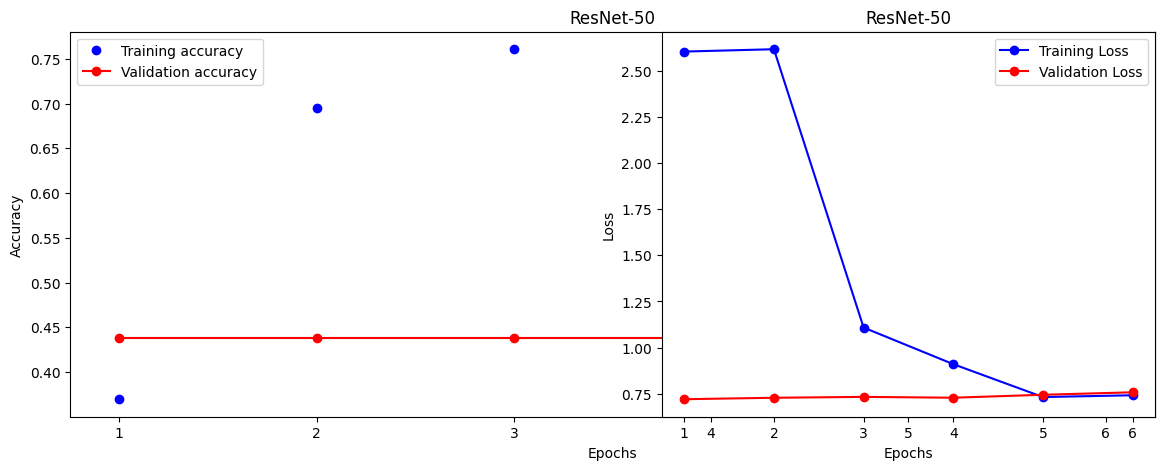

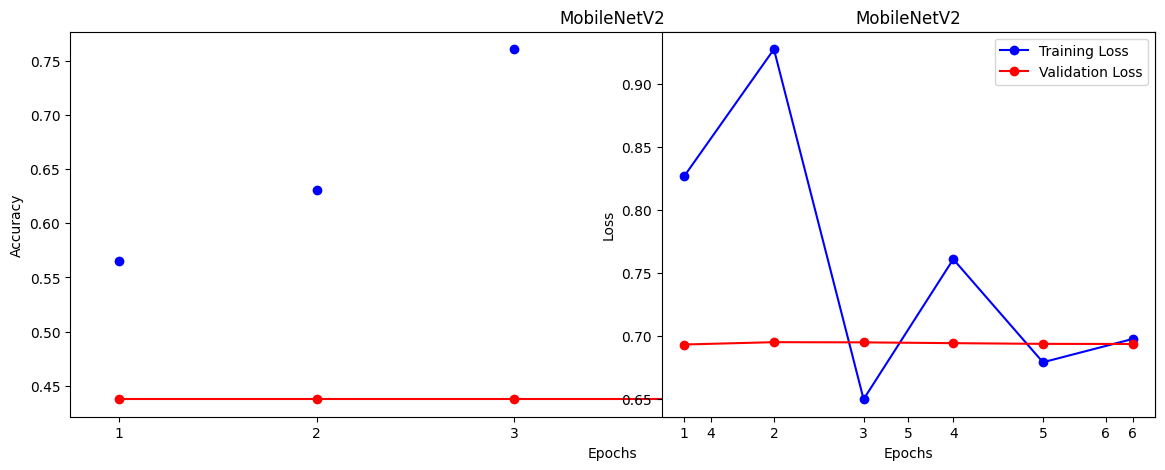

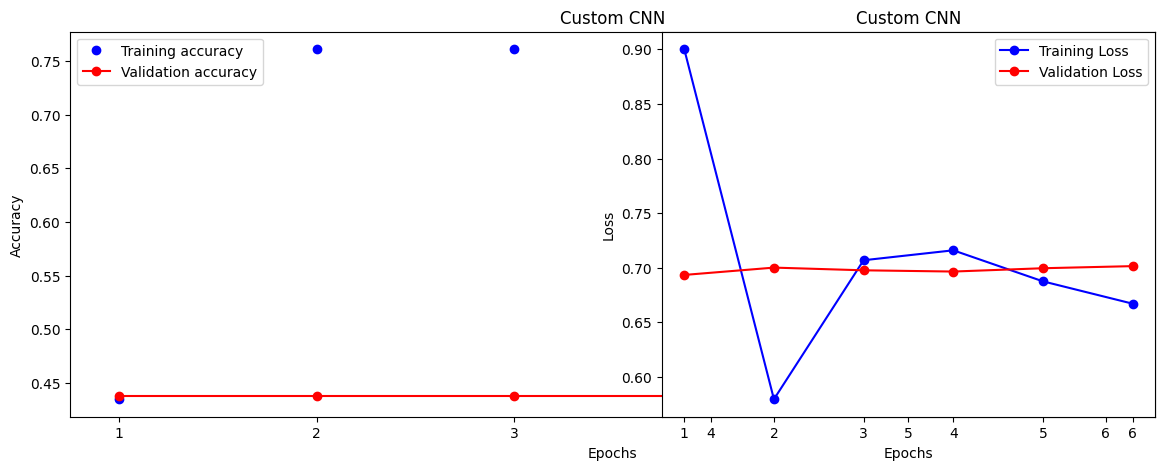

In [59]:
# plotting the accuracy/loss for each model
plot_train_validation_output(resne_op, "ResNet-50")
plot_train_validation_output(mobilenet_op, "MobileNetV2")
plot_train_validation_output(custom_op, "Custom CNN")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


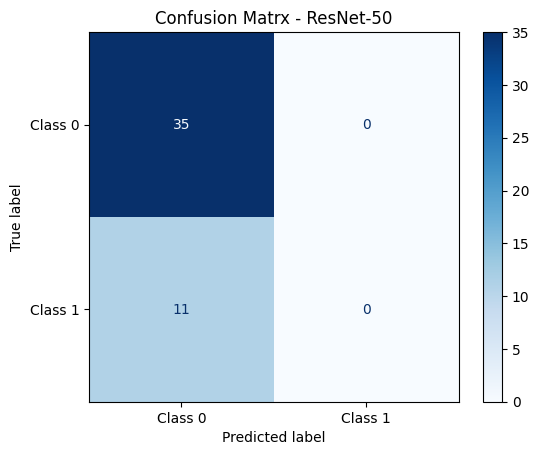

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step


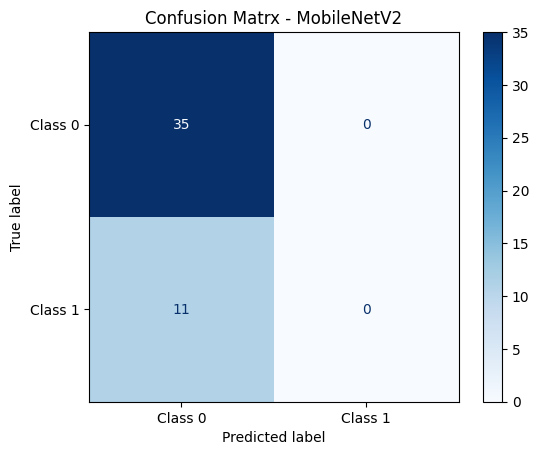

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


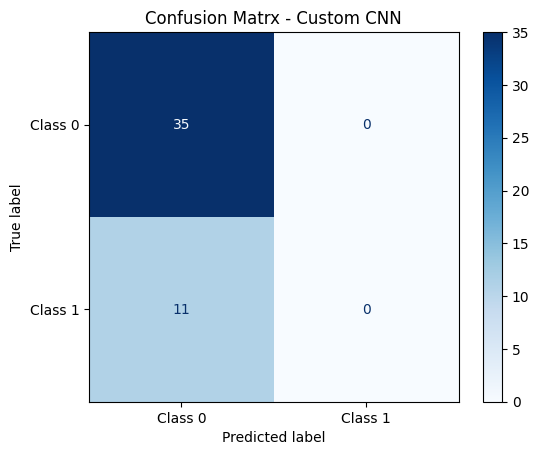

In [62]:
#  function to plot the confusion matrix to see how well the model predicts on the training dataset

def conf_mat(model, dataset, model_name):
  t_label = []
  preds = []

  #  iterating over the test dataset
  for i, l in dataset:
    # getting the predictions for the batch
    p = model.predict(i)

    # appending the true value of the labels and the predicted values in appropriate lists
    t_label.extend(np.argmax(l,axis=1))
    preds.extend(np.argmax(p,axis=1))

  #  using sklearn confusion matrix to generate the confusion matrix
  cm = confusion_matrix(t_label, preds)
  # displaying the confusion matrix
  display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=["Class 0", "Class 1"]
                                   )
  display.plot(cmap=plt.cm.Blues)
  plt.title(f"Confusion Matrx - {model_name}")
  plt.show()

# loading all the models again for the purpose of confusion matrix
resnet_cm = tf.keras.models.load_model("resnet_50.keras")
mobilenet_cm = tf.keras.models.load_model("mobilenet.keras")
custom_cm = tf.keras.models.load_model("custom_cnn.keras")

# plotting the confusion matrix
conf_mat(resnet_cm, train_dataset, "ResNet-50")
conf_mat(mobilenet_cm, train_dataset, "MobileNetV2")
conf_mat(custom_cm, train_dataset, "Custom CNN")

